# PEC2: APRENDIZAJE POR REFUERZO

Toma el notebook 01_bandido_multiarmado_clásico_Thompson_sampling.ipynb e implementa en ese escenario a continuación el algoritmo de bandidos ε-voraz explicado en la transparencia 8 del bloque 1:

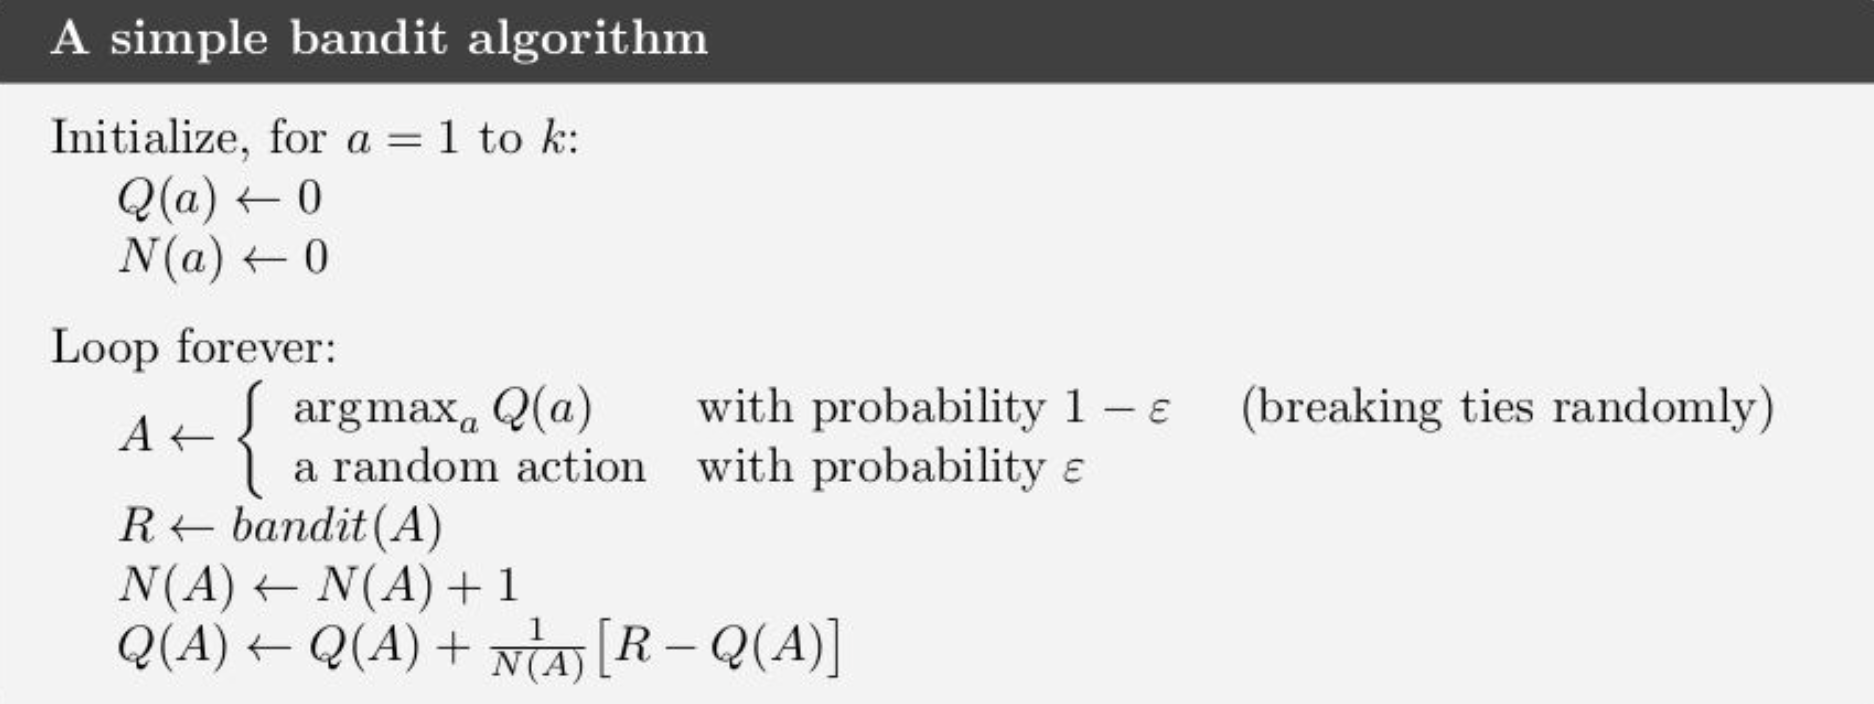

Para la resolución de este ejercicio de la PEC, se va a utilizar el notebook mencionado en el enunciado modificando únicamente la parte correspondiente al agente, que en el caso del enunciado era un algoritmo Thompson sampling, mientras que en este caso será el algoritmo ε-voraz.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Thompson-sampling" data-toc-modified-id="Thompson-sampling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><em>Thompson sampling</em></a></span></li><li><span><a href="#Creamos-el-entorno-con-la-verdad-subyaciente" data-toc-modified-id="Creamos-el-entorno-con-la-verdad-subyaciente-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creamos el entorno con la verdad subyaciente</a></span></li><li><span><a href="#Experimentamos-el-muestro-Thompson" data-toc-modified-id="Experimentamos-el-muestro-Thompson-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experimentamos el muestro Thompson</a></span></li><li><span><a href="#Analysis-of-actions-taken" data-toc-modified-id="Analysis-of-actions-taken-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analysis of actions taken</a></span></li><li><span><a href="#Ampliación" data-toc-modified-id="Ampliación-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ampliación</a></span></li></ul></div>

# *Thompson sampling*

<img src='linearts.png'>

Creamos un ejemplo sencillo para un bandido multiarmado básico (sin contexto), y dos acciones que suponemos se distribuyen como una normal desconocida:

$$X_i \sim \mathcal{N}(\mu_i, \sigma_i) \ \ \  i=1,2$$

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display
%matplotlib inline

Creamos un muestreador de normales

In [3]:
def sample_normal(mu, sigma, noise_width=0.0):
    """
    Función que devolver valores de una distribución normal generada a partir de los parámetros dados.
    
    - mu: media de la distribución.
    - sigma: desviación estándar de la distribución.
    - noise_width: ruido a la hora de generar la distribución
    
    - return: rs -> valor dentro de la distribución
    """   
    rn = np.random.randn()
    rs = mu + sigma * rn
    
    if noise_width > 0:
        rs += np.random.randn() * noise_width
    
    return rs

sample_normal(3.0, 2, noise_width=0.5)

2.679462472579133

# Creamos el entorno con la verdad subyaciente

Generamos 3 acciones con distintas medias que suponen los beneficios reales desconocidos (el entorno del problema de bandidos estocásticos a resolver):

In [4]:
ground_truth_df = pd.DataFrame({'mu': [1.5, 2.0, 1.7],
                                'sigma': [0.8, 0.3, 0.2]},
                               index=['action_%s' % str(k) for k in np.arange(1, 4)])
ground_truth_df

,mu,sigma
action_1,1.5,0.8
action_2,2.0,0.3
action_3,1.7,0.2


Representamos sus funciones de densidad

In [5]:
SAMPLE_SIZE= 1000
action_samples_dict = {}

for action in ground_truth_df.index:
    
    mu = ground_truth_df.loc[action, 'mu']
    sigma = ground_truth_df.loc[action, 'sigma']
    
    action_samples_dict[action] = [sample_normal(mu, sigma) for k in range(SAMPLE_SIZE)]
    
action_samples_df = pd.DataFrame(action_samples_dict)

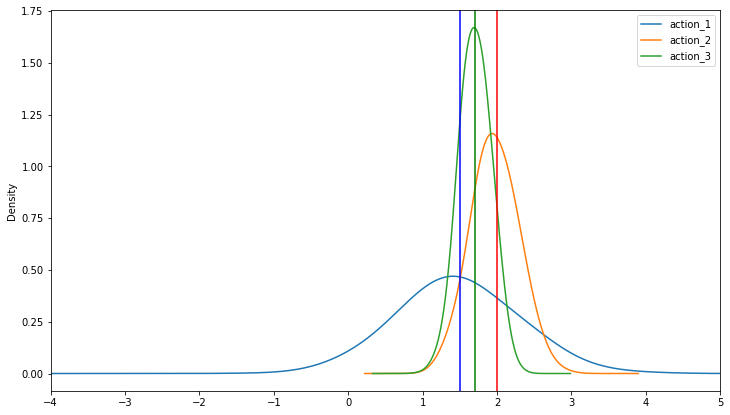

In [6]:
action_samples_df.plot.kde(0.5, figsize=(12, 7));
plt.xlim(-4, 5);
plt.axvline(ground_truth_df.mu.iloc[0], c='b');
plt.axvline(ground_truth_df.mu.iloc[1], c='r');
plt.axvline(ground_truth_df.mu.iloc[2], c='g');

# Experimento ε-voraz

En este apartado se va a proceder a la implementación del algoritmo ε-voraz en vez del thompson sampling. Una vez se ha generado la verdad subyacente y el muestreador, se procede a crear una función que incluirá la verdad estimada, un histórico con la acción y la recompensa obtenida, y el agente, que será la implementación del algoritmo, para lo cuál habrá que coneguir que un porcentaje ε de veces se escoge una acción de forma aleatoria en vez de escoger la acción que maximice la recompensa. Para el cálculo de la recompensa, la función del enunciado simplemente hace la media del histórico de recompenas tras haber añadido la nueva recompensa generada.

In [7]:
def epsilon_voraz(eps, EXPERIMENT_SIZE):
    """
    Función que implementa al algoritmo epsilon voraz.
    
    - eps: parámetro epsilon
    - EXPERIMENT_SIZE: número de iteraciones
    
    - return:historical_df -> histórico de acciones y recompensas tras el experimento
    - return:estimated_truth_df -> vverdad estimada tras el experimento
    """
    
    # Se genera la verdad estimada
    estimated_truth_df = ground_truth_df.copy()
    estimated_truth_df['mu'] = 0.0
    estimated_truth_df['sigma'] = 1.0
    
    # Se genera el histórico de recompensas
    historical_df = pd.DataFrame(columns=['action', 'reward'])


    for k in tqdm(range(EXPERIMENT_SIZE)):

        # Se muestrea un valore de recompensa para cada acción a partir de las distribuciones de la verdad estimada
        sample_estimated_reward = pd.Series([sample_normal(**estimated_truth_df.loc[key].to_dict())
                                             for key in estimated_truth_df.index],
                                            index=estimated_truth_df.index)
        
        # Probabilidad aleatoria de 0 a 1
        p = np.random.random()
        
        # Implementación del algoritmo. Si la probabilidad es menor a epsilon, se escoge una acción aleatoriamente.
        # Si la probabilidad es mayor a epsilon, se escoge la acción que maximice la recompensa
        if (p < eps):
            selected_action = np.random.choice(['action_1', 'action_2', 'action_3'])
        else:
            selected_action = sample_estimated_reward.idxmax()

        # get reward from action sampling from rewards groundtruth distributions
        # Obtener una recompensa a partir de la distribución de la verdad subyacente correspondiente a la acción seleccionada
        sample_dict = ground_truth_df.loc[selected_action].to_dict()
        sample_dict['noise_width'] = 0.1
        reward = sample_normal(**sample_dict)

        # Añadir la recompensa y la acción al histórico
        historical_df = historical_df.append(pd.Series({'action': selected_action, 'reward': reward}), 
                                             ignore_index=True)
        
        # update estimated reward distribution for performed action
        # Actualizar la verdad estimada con el nuevo valor de la recompensa
        action_historical_reward_series = historical_df.loc[historical_df.action.eq(selected_action), 'reward']
        updated_mu_value = action_historical_reward_series.mean()
        updated_sigma_value = action_historical_reward_series.std()

        estimated_truth_df.loc[selected_action, 'mu'] = updated_mu_value
        
        # Cuando solo haya un valor en el histórico, la desviación estándar será nula, por lo que hay que evitar añadir un valor nulo al histórico
        if pd.notnull(updated_sigma_value):
            estimated_truth_df.loc[selected_action, 'sigma'] = updated_sigma_value
    return historical_df, estimated_truth_df

In [8]:
historical_df_5, estimated_truth_df_5 = epsilon_voraz(0.05, 1000)
historical_df_1, estimated_truth_df_1 = epsilon_voraz(0.1, 1000)
historical_df_15, estimated_truth_df_15 = epsilon_voraz(0.15, 1000)

100%|██████████| 1000/1000 [00:02<00:00, 364.19it/s]


Se muestran los históricos de los 3 experimentos

In [14]:
display(historical_df_5.head())
display(historical_df_1.head())
display(historical_df_15.head())

,action,reward
0,action_1,1.493769
1,action_3,1.601800
2,action_3,1.322806
3,action_1,0.848170
4,action_1,2.245998


,action,reward
0,action_3,1.820284
1,action_2,2.188686
2,action_3,1.525784
3,action_3,1.622545
4,action_2,2.124943


,action,reward
0,action_1,1.262905
1,action_1,2.473748
2,action_1,2.048392
3,action_1,1.438141
4,action_1,2.018269


Se muestran las verdades estimadas de los 3 experimentos.

In [16]:
display(estimated_truth_df_5)
display(estimated_truth_df_1)
display(estimated_truth_df_15)
display(ground_truth_df)

,mu,sigma
action_1,1.557050,0.773396
action_2,1.990978,0.310487
action_3,1.696772,0.224252


,mu,sigma
action_1,1.427643,0.800272
action_2,1.997772,0.318951
action_3,1.713104,0.230126


,mu,sigma
action_1,1.450004,0.811805
action_2,2.015232,0.307747
action_3,1.675710,0.213265


,mu,sigma
action_1,1.5,0.8
action_2,2.0,0.3
action_3,1.7,0.2


Se observa como en los 3 casos se consigue una buena aproximación de los resultados.

# Analysis of actions taken

Por último, se analizan los resultados

In [23]:
historical_df_5['group'] = historical_df_5.index.to_series() // 10
historical_df_1['group'] = historical_df_1.index.to_series() // 10
historical_df_15['group'] = historical_df_15.index.to_series() // 10

In [24]:
historical_action_props_5 = historical_df_5.groupby('group').action.value_counts(normalize=True).unstack().fillna(0.0)
historical_reward_values_5 = historical_df_5.groupby('group').reward.mean()
historical_report_df_5 = pd.concat([historical_action_props_5, historical_reward_values_5], axis=1)

historical_action_props_1 = historical_df_1.groupby('group').action.value_counts(normalize=True).unstack().fillna(0.0)
historical_reward_values_1 = historical_df_1.groupby('group').reward.mean()
historical_report_df_1 = pd.concat([historical_action_props_1, historical_reward_values_1], axis=1)

historical_action_props_15 = historical_df_15.groupby('group').action.value_counts(normalize=True).unstack().fillna(0.0)
historical_reward_values_15 = historical_df_15.groupby('group').reward.mean()
historical_report_df_15 = pd.concat([historical_action_props_15, historical_reward_values_15], axis=1)

In [25]:
display(historical_report_df_5.head())
display(historical_report_df_1.head())
display(historical_report_df_15.head())

,action_1,action_2,action_3,reward
group,,,,
0,0.4,0.0,0.6,1.491638
1,0.6,0.0,0.4,1.645235
2,0.5,0.2,0.3,1.924008
3,0.5,0.3,0.2,1.808021
4,0.3,0.5,0.2,1.932679


,action_1,action_2,action_3,reward
group,,,,
0,0.0,0.7,0.3,2.048731
1,0.0,0.9,0.1,1.956519
2,0.0,0.7,0.3,1.933598
3,0.0,0.9,0.1,1.967361
4,0.1,0.7,0.2,2.000708


,action_1,action_2,action_3,reward
group,,,,
0,1.0,0.0,0.0,1.625041
1,0.6,0.0,0.4,1.764117
2,0.5,0.0,0.5,1.310725
3,0.6,0.1,0.3,1.409056
4,0.2,0.7,0.1,2.000466


Se generan gráfico de análisis a partir de los resultados obtenidos.

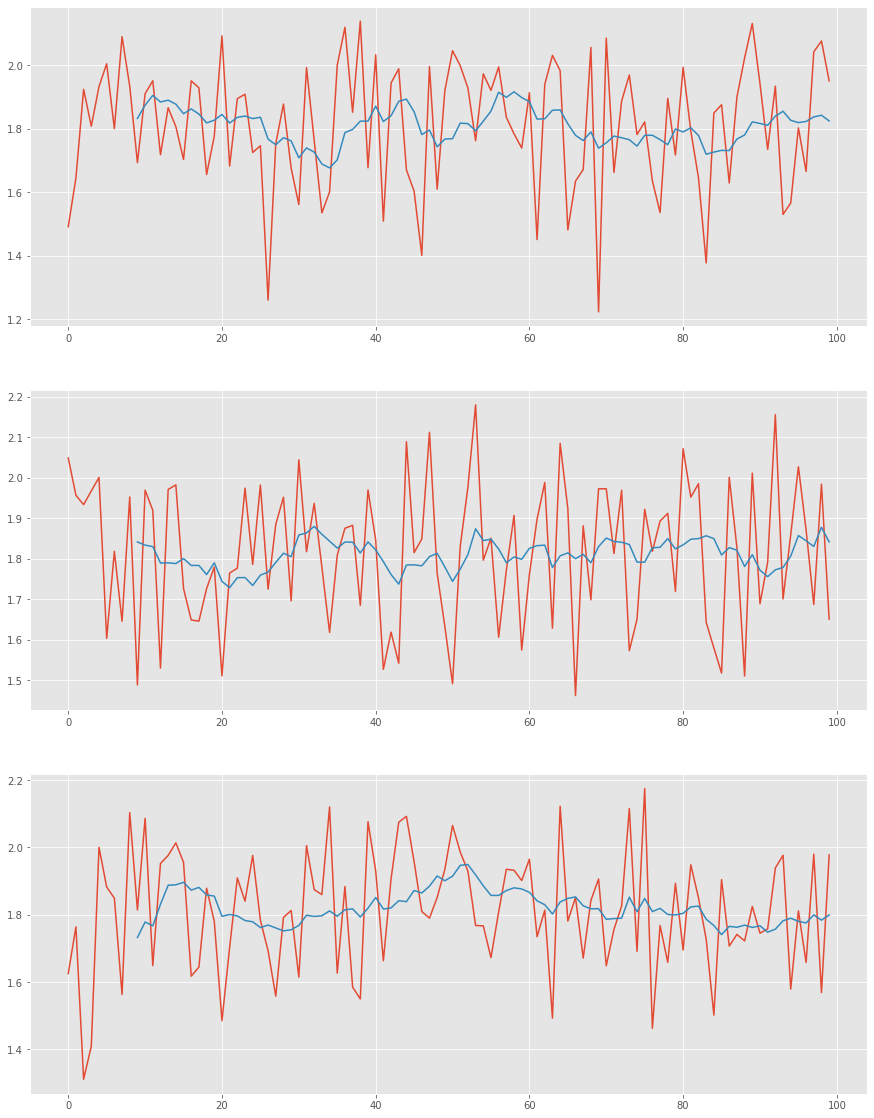

In [53]:
f,ax = plt.subplots(3,1,figsize=(15,20))
ejes = ax.ravel()
ejes[0].plot(historical_reward_values_5);
ejes[0].plot(historical_reward_values_5.rolling(10).mean());

ejes[1].plot(historical_reward_values_1);
ejes[1].plot(historical_reward_values_1.rolling(10).mean());

ejes[2].plot(historical_reward_values_15);
ejes[2].plot(historical_reward_values_15.rolling(10).mean());

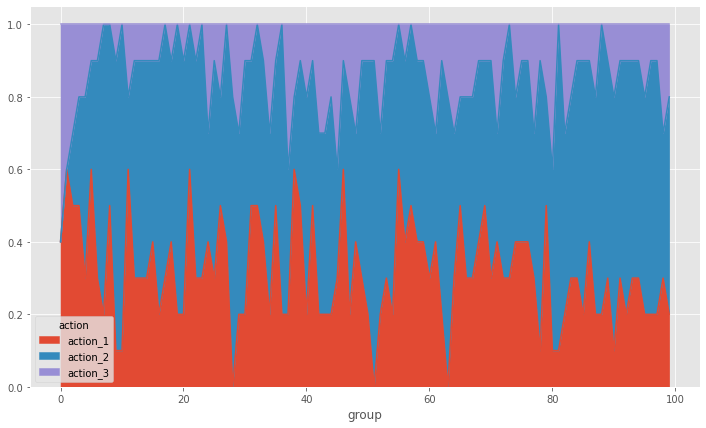

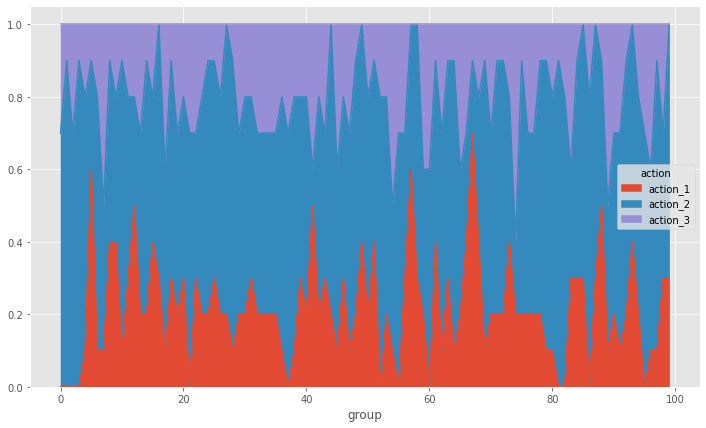

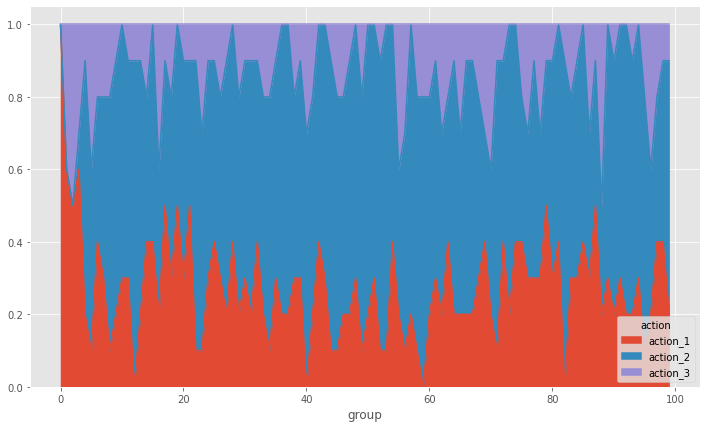

In [56]:
historical_action_props_5.plot.area(figsize=(12, 7));
historical_action_props_1.plot.area(figsize=(12, 7));
historical_action_props_15.plot.area(figsize=(12, 7));

Se puede observar como en la mayoría de ocasiones se escoge la acción 2, que es la que tiene una media mayor.


# Ampliación

- GLM Thompson sampling https://github.com/patrickmineault/xcorr-notebooks/blob/master/Contextual%20bandits%20with%20Thompson%20sampling.ipynb